# **Maxime's Notebook - Focus on Cycle GAN**

what is a cycle gan ?  
CycleGAN augmentation → Image dataset → Classification model (CNN, ResNet, etc.) → Soil type prediction

In [1]:
# Install necessary packages

import os
import matplotlib.pyplot as plt
import torchvision
import random
import shutil
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import time
import gc
from tqdm.auto import tqdm

In [2]:
## Etape 0 : Initialisation des dossiers

# Suppression du dossier Renamed-Dataset s'il existe
if os.path.exists("../data/Renamed-Dataset"):
    shutil.rmtree("../data/Renamed-Dataset")

In [3]:
## Étape 1 : Copier et renommer les dossiers

# Dossier parent contenant les sous-dossiers de sols
parent_dir = r"..\data\Orignal-Dataset/"
renamed_dir = r"..\data\Renamed-Dataset/"

# Créer le dossier renommé s'il n'existe pas
os.makedirs(renamed_dir, exist_ok=True)

# Liste des anciens et nouveaux noms
folder_mapping = {
    "Alluvial_Soil": "type1",
    "Arid_Soil": "type2",
    "Black_Soil": "type3",
    "Laterite_Soil": "type4",
    "Mountain_Soil": "type5",
    "Red_Soil": "type6",
    "Yellow_Soil": "type7"
}

# Copier et renommer les dossiers
for old_name, new_name in folder_mapping.items():
    old_path = os.path.join(parent_dir, old_name)
    new_path = os.path.join(renamed_dir, new_name)
    if os.path.exists(old_path):
        # Supprimer le dossier de destination s'il existe déjà
        if os.path.exists(new_path):
            shutil.rmtree(new_path)
        shutil.copytree(old_path, new_path)

print("Copie et renommage des dossiers terminés.")


Copie et renommage des dossiers terminés.


In [4]:
## Étape 2 : Conversion des images en .jpg

def convert_images_to_jpg(folder_path):
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                filepath = os.path.join(class_path, file_name)
                # Si l'image n'est pas déjà en .jpg, la convertir
                if os.path.isfile(filepath) and not file_name.lower().endswith('.jpg'):
                    try:
                        img = Image.open(filepath)
                        # Convertir en RGB (au cas où l'image a un canal alpha)
                        if img.mode != 'RGB':
                            img = img.convert('RGB')
                        # Sauvegarder en .jpg avec le même nom
                        new_filename = os.path.splitext(file_name)[0] + '.jpg'
                        new_filepath = os.path.join(class_path, new_filename)
                        img.save(new_filepath, 'JPEG', quality=95)
                        # Supprimer le fichier original si ce n'est pas déjà du .jpg
                        if file_name != new_filename:
                            os.remove(filepath)
                    except Exception as e:
                        print(f"Erreur avec {file_name}: {e}")

# Convertir les images dans le dossier renommé
convert_images_to_jpg(renamed_dir)
print("Conversion des images en .jpg terminée.")


Conversion des images en .jpg terminée.


In [5]:
## Étape 3 : Redimensionner les images à 256x256 pixels

def resize_images_in_folder(folder_path, size=(256, 256)):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.jpg'):
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                img = img.resize(size, Image.LANCZOS)
                img.save(img_path)
            else:
                print(f"Le fichier {file} n'est pas au format .jpg et sera ignoré.")

# Redimensionner les images dans le dossier renommé
resize_images_in_folder(renamed_dir)
print("Redimensionnement des images terminé.")


Redimensionnement des images terminé.


In [6]:
## Vérification des nombres d'images par classe

def count_images_in_folder(folder_path):
    count_dict = {}
    for root, dirs, files in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = len([f for f in os.listdir(dir_path)])
            count_dict[dir_name] = count
    return count_dict

parent_counts = count_images_in_folder(renamed_dir)
print("\nNombre d'images par classe dans le dossier parent:")
for class_name, count in parent_counts.items():
    print(f"{class_name}: {count} images")


Nombre d'images par classe dans le dossier parent:
type1: 52 images
type2: 284 images
type3: 255 images
type4: 219 images
type5: 201 images
type6: 109 images
type7: 69 images


In [7]:
## Étape 4 : Train/Test split et création des dossiers train et test

# Créer les sous-dossiers pour train et test
for i in range(1, 8):
    os.makedirs(os.path.join(renamed_dir, "train", f"type{i}"), exist_ok=True)
    os.makedirs(os.path.join(renamed_dir, "test", f"type{i}"), exist_ok=True)

# Répartir les images avec train_test_split
for index, (old_name, new_name) in enumerate(folder_mapping.items()):
    class_dir = os.path.join(renamed_dir, new_name)
    images = [f for f in os.listdir(class_dir) if f.endswith('.jpg')]
    train_images, test_images = train_test_split(images, test_size=0.3, random_state=42)

    # Déplacer les images vers les dossiers train et test
    for img in train_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(renamed_dir, "train", new_name, img))
    for img in test_images:
        shutil.move(os.path.join(class_dir, img), os.path.join(renamed_dir, "test", new_name, img))

    # Supprimer le dossier vide
    os.rmdir(class_dir)

print("Répartition des images terminée.")


Répartition des images terminée.


In [8]:
## Comparaison du nombre d'images dans chaque dossier

train_counts = count_images_in_folder(os.path.join(renamed_dir, "train"))
test_counts = count_images_in_folder(os.path.join(renamed_dir, "test"))
parent_counts = count_images_in_folder(parent_dir)

print("Nombre d'images par classe dans le dossier 'train':")
for class_name, count in train_counts.items():
    print(f"{class_name}: {count} images")

print("\nNombre d'images par classe dans le dossier 'test':")
for class_name, count in test_counts.items():
    print(f"{class_name}: {count} images")

print("\nNombre d'images par classe dans le dossier parent:")
for class_name, count in parent_counts.items():
    print(f"{class_name}: {count} images")

Nombre d'images par classe dans le dossier 'train':
type1: 36 images
type2: 198 images
type3: 178 images
type4: 153 images
type5: 140 images
type6: 76 images
type7: 48 images

Nombre d'images par classe dans le dossier 'test':
type1: 16 images
type2: 86 images
type3: 77 images
type4: 66 images
type5: 61 images
type6: 33 images
type7: 21 images

Nombre d'images par classe dans le dossier parent:
Alluvial_Soil: 52 images
Arid_Soil: 284 images
Black_Soil: 255 images
Laterite_Soil: 219 images
Mountain_Soil: 201 images
Red_Soil: 109 images
Yellow_Soil: 69 images


In [9]:
# Vérification que train + test = parent (en utilisant folder_mapping pour la correspondance)
print("\nVérification que train + test = parent:")
for old_name, new_name in folder_mapping.items():
    total = train_counts.get(new_name, 0) + test_counts.get(new_name, 0)
    parent_total = parent_counts.get(old_name, 0)
    print(f"{old_name} ({new_name}): train + test = {total}, parent = {parent_total}, égalité: {total == parent_total}")



Vérification que train + test = parent:
Alluvial_Soil (type1): train + test = 52, parent = 52, égalité: True
Arid_Soil (type2): train + test = 284, parent = 284, égalité: True
Black_Soil (type3): train + test = 255, parent = 255, égalité: True
Laterite_Soil (type4): train + test = 219, parent = 219, égalité: True
Mountain_Soil (type5): train + test = 201, parent = 201, égalité: True
Red_Soil (type6): train + test = 109, parent = 109, égalité: True
Yellow_Soil (type7): train + test = 69, parent = 69, égalité: True


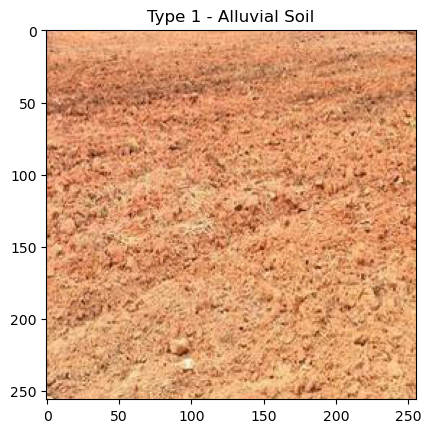

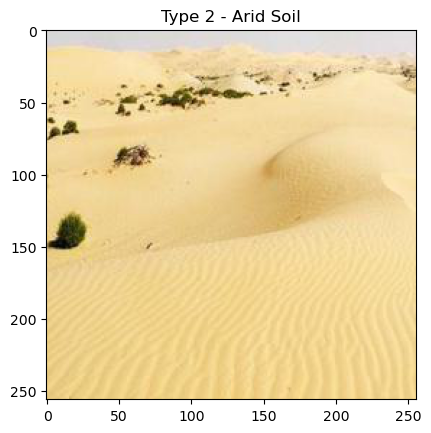

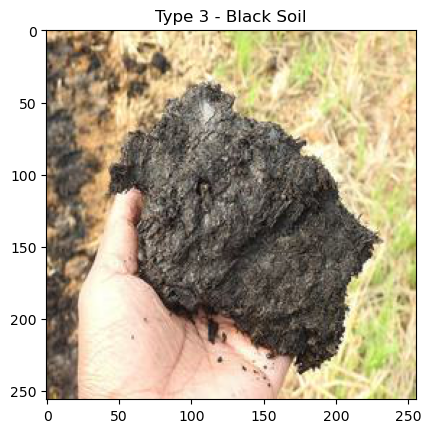

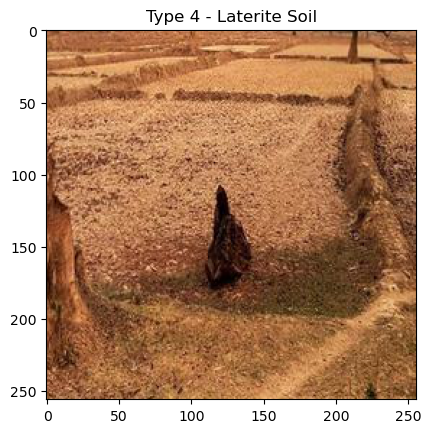

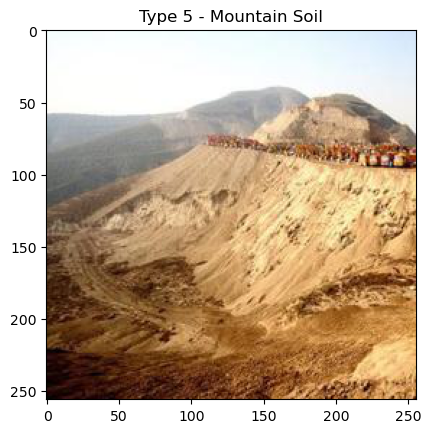

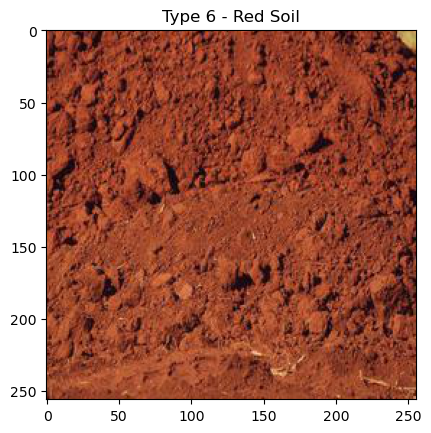

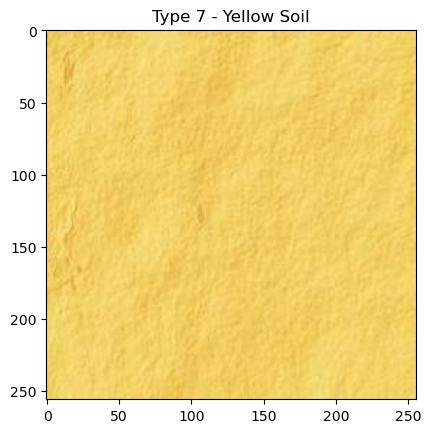

In [10]:
## Affichage d'image aléatoire en affichant le type de sol

# Créer un dictionnaire inversé pour retrouver les noms originaux
inverse_mapping = {v: k for k, v in folder_mapping.items()}

for i in range(1, 8):
    train_dir = os.path.join(renamed_dir, "train", f"type{i}")
    sample_img = random.choice(os.listdir(train_dir))
    img_path = os.path.join(train_dir, sample_img)
    img = Image.open(img_path)
    plt.imshow(img)
    soil_name = inverse_mapping[f"type{i}"].replace("_", " ")
    plt.title(f"Type {i} - {soil_name}")
    plt.show()


In [11]:
## Étape 5 : Création d'une classe Dataset personnalisée

class SolDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.images = []
        self.domains = []

        # Parcourir les sous-dossiers de root_dir (train ou test)
        for domain_idx, domain in enumerate(sorted(os.listdir(root_dir)), start=1):
            domain_path = os.path.join(root_dir, domain)
            for img_name in os.listdir(domain_path):
                self.images.append(os.path.join(domain_path, img_name))
                self.domains.append(domain_idx - 1)  # Les labels commencent à 0

    def __getitem__(self, index):
        img = Image.open(self.images[index]).convert('RGB')
        domain = self.domains[index]
        if self.transform:
            img = self.transform(img)
        return img, domain

    def __len__(self):
        return len(self.images)


In [12]:
## Étape 6.1 : Définir les transformations

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Redimensionner à 256x256
    transforms.ToTensor(),          # Convertir en tenseur
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normaliser entre -1 et 1
])

In [13]:
## Etape 6.2 : Créer les datasets et dataloaders

train_dataset = SolDataset(os.path.join(renamed_dir, "train"), transform=transform)
test_dataset = SolDataset(os.path.join(renamed_dir, "test"), transform=transform)

# Réduction du batch size pour éviter les problèmes de mémoire
# num_workers=0 pour éviter les problèmes de multiprocessing sur Windows
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=True)

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Etape 7.1 : Définition du générateur et du discriminateur

class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.InstanceNorm2d(dim),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim, dim, 3, 1, 1),
            nn.InstanceNorm2d(dim)
        )

    def forward(self, x):
        return x + self.block(x)

class Generator(nn.Module):
    def __init__(self, num_domains=5, dim=64):
        super(Generator, self).__init__()
        # Couches initiales
        self.conv1 = nn.Conv2d(3, dim, 7, 1, 3)
        self.norm1 = nn.InstanceNorm2d(dim)

        # Blocs résiduels
        self.res_blocks = nn.Sequential(*[ResidualBlock(dim) for _ in range(6)])

        # Couche pour intégrer le vecteur de domaine
        self.domain_embedding = nn.Sequential(
            nn.Linear(num_domains, dim * 256),
            nn.ReLU(inplace=True),
            nn.Linear(dim * 256, dim),
            nn.ReLU(inplace=True)
        )

        # Couches finales
        self.conv2 = nn.Conv2d(dim, 3, 7, 1, 3)

    def forward(self, x, domain):
        # Encoder l'image
        x = F.relu(self.norm1(self.conv1(x)))

        # Passer par les blocs résiduels
        x = self.res_blocks(x)

        # Intégrer le vecteur de domaine (broadcasting sur les canaux)
        domain_embedding = self.domain_embedding(domain)  # Shape: (batch_size, dim)
        domain_embedding = domain_embedding.view(-1, 64, 1, 1)  # Reshape: (batch_size, 64, 1, 1)
        x = x + domain_embedding  # Broadcasting automatique sur les dimensions spatiales

        # Décoder l'image
        return torch.tanh(self.conv2(x))

class Discriminator(nn.Module):
    def __init__(self, num_domains=5, dim=64):
        super(Discriminator, self).__init__()
        # Couches initiales
        self.conv1 = nn.Conv2d(3, dim, 4, 2, 1)
        self.conv2 = nn.Conv2d(dim, dim * 2, 4, 2, 1)
        self.norm2 = nn.InstanceNorm2d(dim * 2)

        # Couches pour la prédiction adversariale (réelle/fausse)
        self.adv_layer = nn.Conv2d(dim * 2, 1, 3, 1, 1)

        # Couches pour la prédiction de domaine (avec global pooling)
        self.domain_conv = nn.Conv2d(dim * 2, num_domains, 3, 1, 1)
        self.global_pool = nn.AdaptiveAvgPool2d(1)

    def forward(self, x):
        # Extraire les caractéristiques
        x = F.leaky_relu(self.conv1(x), 0.2)
        x = F.leaky_relu(self.norm2(self.conv2(x)), 0.2)

        # Prédiction adversariale
        adv_out = self.adv_layer(x)

        # Prédiction de domaine avec global pooling
        domain_features = self.domain_conv(x)
        domain_out = self.global_pool(domain_features)
        domain_out = domain_out.view(domain_out.size(0), -1)  # (batch, num_domains)

        return adv_out, domain_out


In [15]:
## Étape 7.2 : Initialiser le générateur et le discriminateur

num_domains = 7  # Vous avez 7 types de sols

# Vérifier si CUDA est disponible
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Utilisation du device: {device}")

G = Generator(num_domains).to(device)
D = Discriminator(num_domains).to(device)


Utilisation du device: cpu


In [16]:
## Etape 7.3 : Définir les fonctions de perte et les optimisateurs

loss_bce = nn.BCEWithLogitsLoss()
loss_ce = nn.CrossEntropyLoss()
loss_l1 = nn.L1Loss()

optim_G = torch.optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
optim_D = torch.optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [17]:
def save_sample_images(G, real_images, target_domain, epoch, device, num_domains):
    """
    Generate and save sample images from the generator.

    Args:
        G: Generator model.
        real_images: Batch of real images (only the first 4 are used).
        target_domain: Target domain labels for the images.
        epoch: Current epoch number (used for naming the file).
        device: Device where tensors are located (e.g., 'cuda' or 'cpu').
        num_domains: Number of domains for one-hot encoding.
    """
    with torch.no_grad():
        # Generate one-hot encoding for the target domain
        target_domain_one_hot = F.one_hot(target_domain[:4], num_domains).float().to(device)

        # Generate fake images
        sample_images = G(real_images[:4], target_domain_one_hot)

        # Save the images
        sample_path = os.path.join("samples", f"epoch_{epoch}.png")
        torchvision.utils.save_image(
            sample_images,
            sample_path,
            normalize=True,
            nrow=2  # Optional: Arrange images in a 2x2 grid
        )


In [18]:
## Etape 8.1 : Définir la boucle d'entraînement

def train_step(real_images, source_domain, target_domain):
    # Transfert GPU (avec non_blocking si possible)
    real_images = real_images.to(device, non_blocking=True)
    source_domain = source_domain.to(device, non_blocking=True)
    target_domain = target_domain.to(device, non_blocking=True)

    # Génération des images synthétiques
    target_domain_one_hot = F.one_hot(target_domain, num_domains).float().to(device)
    fake_images = G(real_images, target_domain_one_hot)

    # Mise à jour du discriminateur
    optim_D.zero_grad(set_to_none=True)  # Plus efficace que zero_grad()
    
    real_pred, real_domain_pred = D(real_images)
    fake_pred, fake_domain_pred = D(fake_images.detach())
    ones = torch.ones_like(fake_pred)

    loss_D_adv = loss_bce(fake_pred - real_pred.mean(0), ones)
    loss_D_domain_real = loss_ce(real_domain_pred, source_domain)
    loss_D_domain_fake = loss_ce(fake_domain_pred, target_domain)
    loss_D = loss_D_adv + loss_D_domain_real + loss_D_domain_fake

    loss_D.backward()
    optim_D.step()

    # Mise à jour du générateur
    optim_G.zero_grad(set_to_none=True)  # Plus efficace que zero_grad()
    
    fake_pred, fake_domain_pred = D(fake_images)
    loss_G_adv = loss_bce(fake_pred, ones)
    loss_G_domain = loss_ce(fake_domain_pred, target_domain)

    # Perte de reconstruction
    source_domain_one_hot = F.one_hot(source_domain, num_domains).float().to(device)
    reconstructed_images = G(fake_images, source_domain_one_hot)
    loss_G_rec = loss_l1(reconstructed_images, real_images)
    RECONSTRUCTION_LOSS_WEIGHT = 10
    loss_G = loss_G_adv + loss_G_domain + RECONSTRUCTION_LOSS_WEIGHT * loss_G_rec

    loss_G.backward()
    optim_G.step()

    return {
        "loss_D": loss_D.item(),
        "loss_G": loss_G.item(),
        "loss_D_adv": loss_D_adv.item(),
        "loss_G_adv": loss_G_adv.item(),
        "loss_G_rec": loss_G_rec.item(),
    }

In [19]:
# Configuration
num_epochs = 10
num_domains = 7
SAVE_INTERVAL = 10
SAMPLE_DIR = "samples"
MODEL_DIR = "models"
LOG_DIR = "training_logs"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Nettoyage complet et agressif
gc.collect()
for folder in [LOG_DIR, SAMPLE_DIR, MODEL_DIR]:
    max_attempts = 3
    for attempt in range(max_attempts):
        try:
            if os.path.exists(folder):
                if os.path.isfile(folder):
                    os.remove(folder)
                elif os.path.isdir(folder):
                    shutil.rmtree(folder)
            break
        except Exception as e:
            if attempt < max_attempts - 1:
                time.sleep(1)
            else:
                print(f"Impossible de supprimer {folder}: {e}")
                raise

os.makedirs(SAMPLE_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
writer = SummaryWriter(log_dir=LOG_DIR)
print(f"TensorBoard initialisé dans {LOG_DIR}")

global_step = 0

# Nettoyage de la mémoire avant l'entraînement
if torch.cuda.is_available():
    torch.cuda.empty_cache()
gc.collect()

# Boucle d'entraînement avec gestion des erreurs et affichage amélioré
try:
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        epoch_loss_D, epoch_loss_G = 0, 0
        num_batches = len(train_loader)

        # Barre de progression pour les batches
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as tepoch:
            for batch_idx, (real_images, source_domain) in enumerate(tepoch):
                try:
                    real_images = real_images.to(device, non_blocking=True)
                    source_domain = source_domain.to(device, non_blocking=True)
                    target_domain = torch.randint(0, num_domains, (real_images.size(0),), device=device)

                    losses = train_step(real_images, source_domain, target_domain)

                    # Mise à jour des pertes moyennes pour l'epoch
                    epoch_loss_D += losses["loss_D"]
                    epoch_loss_G += losses["loss_G"]

                    # Logging avec TensorBoard
                    writer.add_scalar("Loss/Discriminator", losses["loss_D"], global_step)
                    writer.add_scalar("Loss/Generator", losses["loss_G"], global_step)
                    writer.add_scalar("Loss/D_Adversarial", losses["loss_D_adv"], global_step)
                    writer.add_scalar("Loss/G_Adversarial", losses["loss_G_adv"], global_step)
                    writer.add_scalar("Loss/G_Reconstruction", losses["loss_G_rec"], global_step)

                    global_step += 1

                    # Affichage des pertes pour le batch actuel dans la barre de progression
                    tepoch.set_postfix(
                        loss_D=losses["loss_D"],
                        loss_G=losses["loss_G"],
                        refresh=False
                    )

                    # Nettoyage de la mémoire tous les 10 batches
                    if batch_idx % 10 == 0 and torch.cuda.is_available():
                        torch.cuda.empty_cache()

                except RuntimeError as e:
                    print(f"\nErreur au batch {batch_idx} de l'epoch {epoch+1}: {e}")
                    if "out of memory" in str(e):
                        print("Mémoire GPU insuffisante. Réduisez le batch size ou la taille du modèle.")
                        if torch.cuda.is_available():
                            torch.cuda.empty_cache()
                        break
                    raise

        # Calcul du temps restant
        epoch_time = time.time() - epoch_start_time
        avg_time_per_epoch = epoch_time
        estimated_time_remaining = (num_epochs - epoch - 1) * avg_time_per_epoch
        print(f"\nEpoch {epoch+1}/{num_epochs} terminé en {epoch_time:.2f}s | Temps restant estimé: {estimated_time_remaining:.2f}s")
        print(f"Pertes moyennes: Loss D: {epoch_loss_D/num_batches:.4f}, Loss G: {epoch_loss_G/num_batches:.4f}")

        # Sauvegarde des échantillons et des modèles
        if epoch % SAVE_INTERVAL == 0:
            save_sample_images(G, real_images, target_domain, epoch, device, num_domains)
            torch.save(G.state_dict(), os.path.join(MODEL_DIR, f"G_epoch_{epoch}.pth"))
            torch.save(D.state_dict(), os.path.join(MODEL_DIR, f"D_epoch_{epoch}.pth"))

        # Nettoyage de la mémoire à la fin de chaque epoch
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        gc.collect()

except Exception as e:
    print(f"Erreur pendant l'entraînement: {e}")
    import traceback
    traceback.print_exc()
finally:
    writer.close()
    print("Writer TensorBoard fermé.")

print("Entraînement terminé !")

TensorBoard initialisé dans training_logs


Epoch 1/10:   0%|          | 0/208 [00:00<?, ?batch/s]

Writer TensorBoard fermé.


KeyboardInterrupt: 